# Historical Returns Distribution fitting

## Normal or not

Before using the Volatility infered from the log-returns normality assumption, it is worth looking into the validity of that assumption.



In [94]:

{
    "tags": [
        "hide_input",
    ]
}

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace

plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

vol_2min = btcusd_1min['ret_2min'].std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


In [15]:
btcusd_1min['ret_2min'].describe()

count    2.987046e+06
mean     5.840184e-06
std      2.935358e-03
min     -4.730853e-01
25%     -6.954727e-04
50%      0.000000e+00
75%      7.275687e-04
max      2.411621e-01
Name: ret_2min, dtype: float64

In [46]:
ret_2min = btcusd_1min['ret_2min'][-180:]
[ret_2min.size,
btcusd_1min['ret_2min'].size]

[180, 2987048]

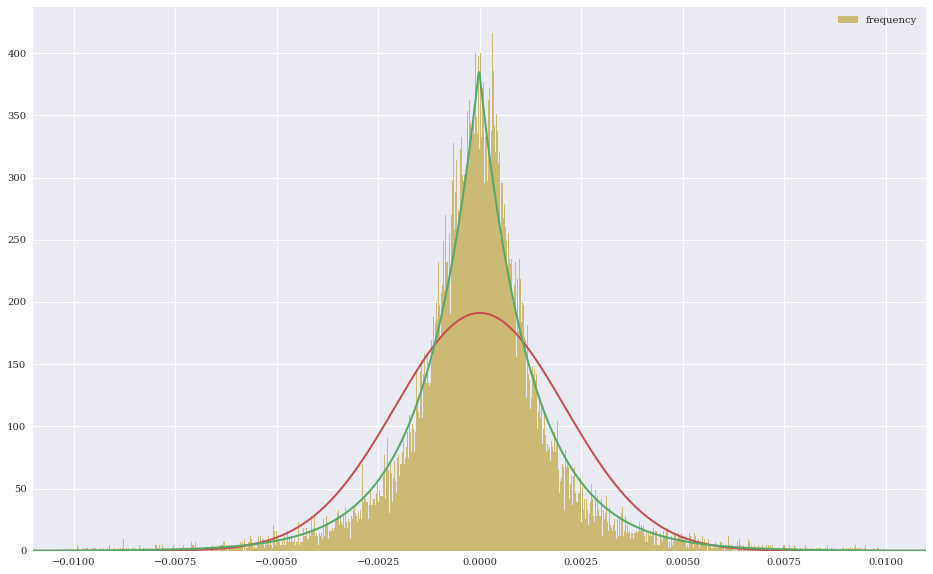

In [115]:
# nb_2min_in_30d = 30*24*60/2 # = 21600
ret_2min = btcusd_1min['ret_2min'][-21600:]
# ret_2min = btcusd_1min['ret_2min'][2:]

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
# plt.title("something")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid',  density=True,         range=[-0.01,0.01]);
plt.legend(loc=0);

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False)

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False)


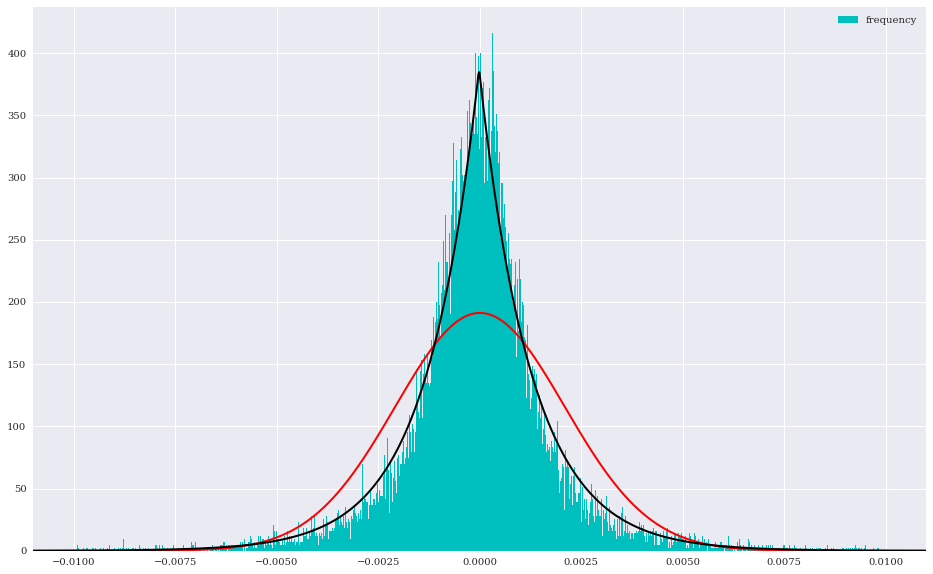

In [111]:
# nb_2min_in_30d = 30*24*60/2 # = 21600
ret_2min = btcusd_1min['ret_2min'][-21600:]
# ret_2min = btcusd_1min['ret_2min'][2:]

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.hist(ret_2min, color='c', bins=1000, label='frequency', align='mid',  density=True, range=[-0.01,0.01]);
plt.legend(loc=0);

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, 'r', linewidth=2, scalex=False, scaley=False)

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, 'k', linewidth=2, scalex=False, scaley=False)


## Normal Distribution


## Laplace Distribution

## Lookback at the sigma levels